In [ ]:
import numpy as np 
import pandas as pd 
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras import backend as K
from keras.layers import Conv2D,MaxPooling2D,UpSampling2D,Input,BatchNormalization,LeakyReLU
from keras.layers.merge import concatenate
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
import tensorflow.compat.v1 as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
tensorflow.random.set_seed(123)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess=tf.Session(graph=tf.get_default_graph(), config=session_conf)
tf.keras.backend.set_session(sess)
tensorflow.random.set_seed(2)
np.random.seed(1)

#print(os.listdir("./images/"))
print(os.listdir("/content/drive/MyDrive/imagesF/"))

['train', 'val']


In [ ]:
HEIGHT=224
WIDTH=224
path=['train']
ImagePath="/content/drive/MyDrive/imagesF/"+str(path[0])+"/class/"
# ImagePath = "./images/"+str(path[0])+"/class/"

def ExtractInput(path):
    X_img=[]
    y_img=[]
    for imageDir in os.listdir(ImagePath):
        try:
            img = cv2.imread(ImagePath + imageDir)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
            # img = img.astype(np.float32)
            img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)

            # resize image to network input size
            img_lab_rs = cv2.resize(img_lab, (WIDTH, HEIGHT)) 
            img_l = img_lab_rs[:,:,0] 

            # pull out L channel    
            img_ab = img_lab_rs[:,:,1:]
            
            # Extracting the ab channel
            img_ab = img_ab/128

            X_img.append(img_l)
            y_img.append(img_ab)
        except:
            pass
    X_img = np.array(X_img)
    y_img = np.array(y_img)
    
    return X_img,y_img

#### Data-preprocessing

In [ ]:
X_ , y_ = ExtractInput(ImagePath)

#### Shape of X is (400,224,224) for 400 input images each of size (224,224) with 1 L channel
#### Shape of Y is (400,224,224,2) for 400 images of size (224,224) with 2 channels A and B 

In [ ]:
X_.shape,y_.shape

((400, 224, 224), (400, 224, 224, 2))

In [ ]:
K.clear_session()

def InstantiateModel(in_):
    model_ = Conv2D(16, (3, 3), padding = 'same', strides = 1)(in_)
    model_ = LeakyReLU()(model_)

    model_ = Conv2D(32, (3, 3), padding = 'same', strides = 1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size = (2, 2), padding = 'same')(model_)
    
    model_ = Conv2D(64, (3, 3), padding = 'same', strides = 1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size = (2, 2), padding = 'same')(model_)
    
    model_ = Conv2D(128, (3, 3), padding = 'same', strides = 1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(256, (3, 3), padding = 'same', strides = 1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = UpSampling2D((2, 2))(model_)
    model_ = Conv2D(128, (3, 3), padding = 'same', strides = 1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = UpSampling2D((2, 2))(model_)
    model_ = Conv2D(64, (3, 3), padding = 'same', strides = 1)(model_)
    model_ = LeakyReLU()(model_)

    #model_ = BatchNormalization()(model_)
    concat_ = concatenate([model_, in_]) 
    
    model_ = Conv2D(64, (3, 3), padding = 'same', strides = 1)(concat_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(32, (3, 3), padding = 'same', strides = 1)(model_)
    model_ = LeakyReLU()(model_)

    #model_ = BatchNormalization()(model_)
    model_ = Conv2D(2, (3, 3), activation = 'tanh', padding = 'same', strides = 1)(model_)

    return model_

In [ ]:
Input_Sample = Input(shape=(HEIGHT, WIDTH,1))
Output_ = InstantiateModel(Input_Sample)
Model_Colourization = Model(inputs=Input_Sample, outputs=Output_)

Tested on different learning rates

In [ ]:
LEARNING_RATE = 0.001
Model_Colourization.compile(optimizer=Adam(lr=LEARNING_RATE),
                            loss='mean_squared_error')
Model_Colourization.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 224, 224, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 32) 4640        leaky_re_lu[0][0]                
______________________________________________________________________________________________

In [ ]:
def GenerateInputs(X_,y_):
    for i in range(len(X_)):
        X_input = X_[i].reshape(1,224,224,1)
        y_input = y_[i].reshape(1,224,224,2)
        yield (X_input,y_input)
Model_Colourization.fit(GenerateInputs(X_,y_),epochs=4,verbose=1,steps_per_epoch=38,shuffle=True)
# validation_data=GenerateInputs(X_val, y_val))

Epoch 1/4
38/38 [==============================] - 55s 1s/step - loss: 0.4814
Epoch 2/4
38/38 [==============================] - 54s 1s/step - loss: 1.9903e-04
Epoch 3/4
38/38 [==============================] - 54s 1s/step - loss: 7.3643e-05
Epoch 4/4
38/38 [==============================] - 54s 1s/step - loss: 5.9906e-05


In [ ]:
TestImagePath="/content/drive/MyDrive/imagesF/"+"val"+"/class/"

# TestImagePath="./images/"+"val"+"/class/"
TestImagePath

'/content/drive/MyDrive/imagesF/val/class/'

In [ ]:
def ExtractTestInput(ImagePath):
    img = cv2.imread(ImagePath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_ = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img_ = cv2.cvtColor(img_, cv2.COLOR_RGB2Lab)
    img_=img_.astype(np.float32)
    img_lab_rs = cv2.resize(img_, (WIDTH, HEIGHT)) 
    
    # resize image to network input size
    img_l = img_lab_rs[:,:,0] 
    
    # pull out L channel
    img_l_reshaped = img_l.reshape(1,224,224,1)
    
    return img_l_reshaped

In [ ]:
ImagePath=TestImagePath+"09c4f97c8e8c836625179841f27afb56.jpg"

# plt.imshow(cv2.imread(ImagePath))
image_for_test = ExtractTestInput(ImagePath)
Prediction = Model_Colourization.predict(image_for_test)
Prediction = Prediction*128
Prediction=Prediction.reshape(224,224,2)

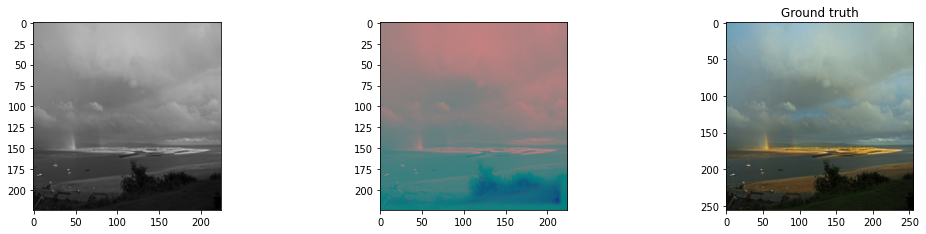

In [ ]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(TestImagePath+"09c4f97c8e8c836625179841f27afb56.jpg")
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (224, 224))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction
plt.imshow(img_)

# img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2BGR)
# plt.title("Predicted Image")
# plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Ground truth")
plt.imshow(img_1)

In [ ]:
ImagePath=TestImagePath+"014869cc7b561871453bf5e813cff812.jpg"
image_for_test = ExtractTestInput(ImagePath)
Prediction_1 = Model_Colourization.predict(image_for_test)
Prediction_1 = Prediction_1*128
Prediction_1=Prediction_1.reshape(224,224,2)

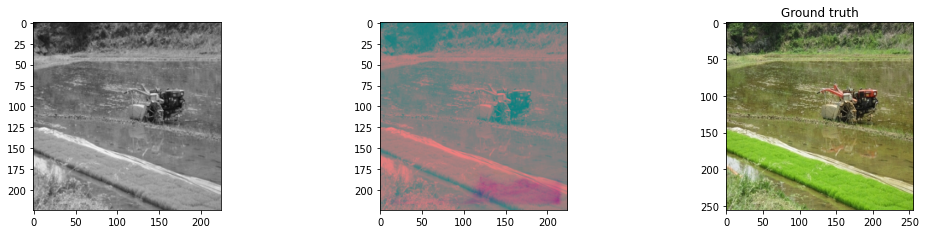

In [ ]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(TestImagePath+"014869cc7b561871453bf5e813cff812.jpg")
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (224, 224))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction
plt.imshow(img_)

# img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2BGR)
# plt.title("Predicted Image")
# plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Ground truth")
plt.imshow(img_1)